# Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy import stats

# Lalonde NSW Dataset

I will use the Lalonde job training dataset for this exercise. This is a very common causal inference example that studied the effects of job trainings on employees' earnings.
> This is a subsample of the data from the treated group in the National Supported Work Demonstration (NSW) and the comparison sample from the Population Survey of Income Dynamics (PSID). This data was previously analyzed extensively by Lalonde (1986) and Dehejia and Wahba (1999). 
https://vincentarelbundock.github.io/Rdatasets/doc/MatchIt/lalonde.html

A data frame with 614 observations (185 treated, 429 control). There are 9 variables measured for each individual.

* "treat" is the treatment assignment (1=treated, 0=control).
* "age" is age in years.
* "educ" is education in number of years of schooling.
* "race" is the individual's race/ethnicity, (Black, Hispanic, or White). Note previous versions of this dataset used indicator variables black and hispan instead of a single race variable.
* "married" is an indicator for married (1=married, 0=not married).
* "nodegree" is an indicator for whether the individual has a high school degree (1=no degree, 0=degree).
* "re74" is income in 1974, in U.S. dollars.
* "re75" is income in 1975, in U.S. dollars.
* "re78" is income in 1978, in U.S. dollars.

# EDA

In [4]:
df = pd.read_csv('Data/lalonde.csv')
df.head()

,rownames,treat,age,educ,race,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,black,0,1,0.0,0.0,289.7899


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   rownames  614 non-null    object 
 1   treat     614 non-null    int64  
 2   age       614 non-null    int64  
 3   educ      614 non-null    int64  
 4   race      614 non-null    object 
 5   married   614 non-null    int64  
 6   nodegree  614 non-null    int64  
 7   re74      614 non-null    float64
 8   re75      614 non-null    float64
 9   re78      614 non-null    float64
dtypes: float64(3), int64(5), object(2)
memory usage: 48.1+ KB


In [6]:
df['race'].value_counts()

race
white     299
black     243
hispan     72
Name: count, dtype: int64

To look for any covariate imbalance or selection bias, we'll compare the standard mean difference (SMD) between the control and treated. SMD is the mean of each fetaure divided by its standard devition. This puts all the vairables on the same unit less scale, because we wouldn't want to compare the vastly different means of income vs age for example.

In [7]:
def calculate_smd(data, features):
    means = data.groupby('treat')[features].mean().T
    stdev = data.groupby('treat')[features].std().T
    diff = means[1] - means[0]
    smd = diff / np.sqrt((stdev[0]**2 + stdev[1]**2) / 2)
    return smd

In [8]:
# compare means and check for imbalances
df = df.drop(columns=['rownames'])
df_encoded = pd.get_dummies(df, columns=['race'], prefix='race')
features = [col for col in df_encoded.columns if col not in ['rownames', 'treat']]
print(features)
# treated and control means before matching
mean_compare = df_encoded.groupby('treat')[features].mean().T
mean_compare['diff'] = mean_compare[1] - mean_compare[0]
mean_compare['smd'] = calculate_smd(df_encoded, features)

print("\n")
print(mean_compare)

['age', 'educ', 'married', 'nodegree', 're74', 're75', 're78', 'race_black', 'race_hispan', 'race_white']


treat                  0            1         diff       smd
age            28.030303    25.816216    -2.214087 -0.241904
educ           10.235431    10.345946     0.110515  0.044755
married         0.512821     0.189189    -0.323631 -0.719492
nodegree        0.596737     0.708108     0.111372  0.235048
re74         5619.236506  2095.573689 -3523.662818 -0.595752
re75         2466.484443  1532.055314  -934.429129 -0.287002
re78         6984.169742  6349.143530  -635.026212 -0.083708
race_black      0.202797     0.843243     0.640446  1.667719
race_hispan     0.142191     0.059459    -0.082732 -0.276940
race_white      0.655012     0.097297    -0.557714 -1.405738


* The treated group leans younger and unmarried, with likely no highschool degree. 
* There is also a heavy imbalance between the races, with control leaning more white and treated leaning more black
* While the mean 1974 earnings of the treated group were much lower than control, they become comparable in 1978
* The NSW program was targeted to the marginalized groups that represent the treated group, but it does present some selection bias for this experiment

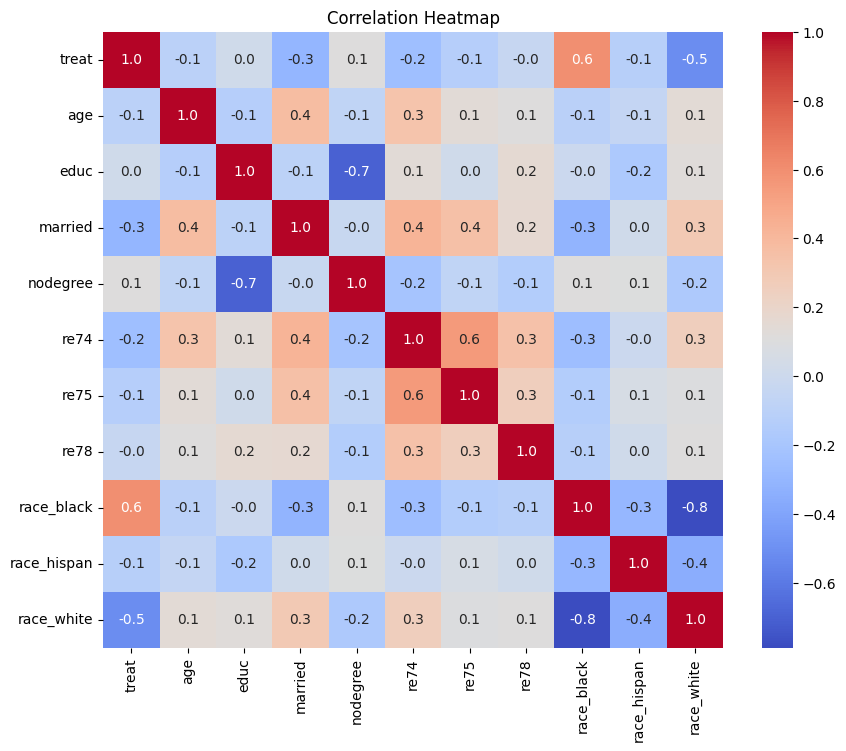

In [9]:
# Correlation heatmap
plt.figure(figsize=(10,8))
corr = df_encoded.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Correlation Heatmap")
plt.savefig('Images/lalonde_correlation_heatmap.png')
plt.show()

In [10]:
corr

,treat,age,educ,married,nodegree,re74,re75,re78,race_black,race_hispan,race_white
treat,1.000000,-0.102893,0.019308,-0.301334,0.105857,-0.249779,-0.130197,-0.039033,0.600907,-0.117983,-0.511959
age,-0.102893,1.000000,-0.125622,0.376059,-0.069218,0.333254,0.140022,0.106249,-0.110730,-0.053400,0.142707
educ,0.019308,-0.125622,1.000000,-0.095051,-0.701452,0.136583,0.018301,0.161538,-0.010528,-0.174153,0.122400
married,-0.301334,0.376059,-0.095051,1.000000,-0.032349,0.425739,0.353824,0.162358,-0.317118,0.021549,0.296385
nodegree,0.105857,-0.069218,-0.701452,-0.032349,1.000000,-0.208751,-0.070412,-0.142418,0.109278,0.100869,-0.171841
re74,-0.249779,0.333254,0.136583,0.425739,-0.208751,1.000000,0.552002,0.343416,-0.257334,-0.007091,0.256330
re75,-0.130197,0.140022,0.018301,0.353824,-0.070412,0.552002,1.000000,0.257659,-0.140374,0.061589,0.097692
re78,-0.039033,0.106249,0.161538,0.162358,-0.142418,0.343416,0.257659,1.000000,-0.120977,0.015325,0.108494
race_black,0.600907,-0.110730,-0.010528,-0.317118,0.109278,-0.257334,-0.140374,-0.120977,1.000000,-0.294973,-0.788491
race_hispan,-0.117983,-0.053400,-0.174153,0.021549,0.100869,-0.007091,0.061589,0.015325,-0.294973,1.000000,-0.355097


Some of these correlations are obvious like age and married or education length and nodegree. But we do see a strong score with treatment and the races, affirming the selection bias here.

Want to take a final look at density plots to emphasize these sample differences

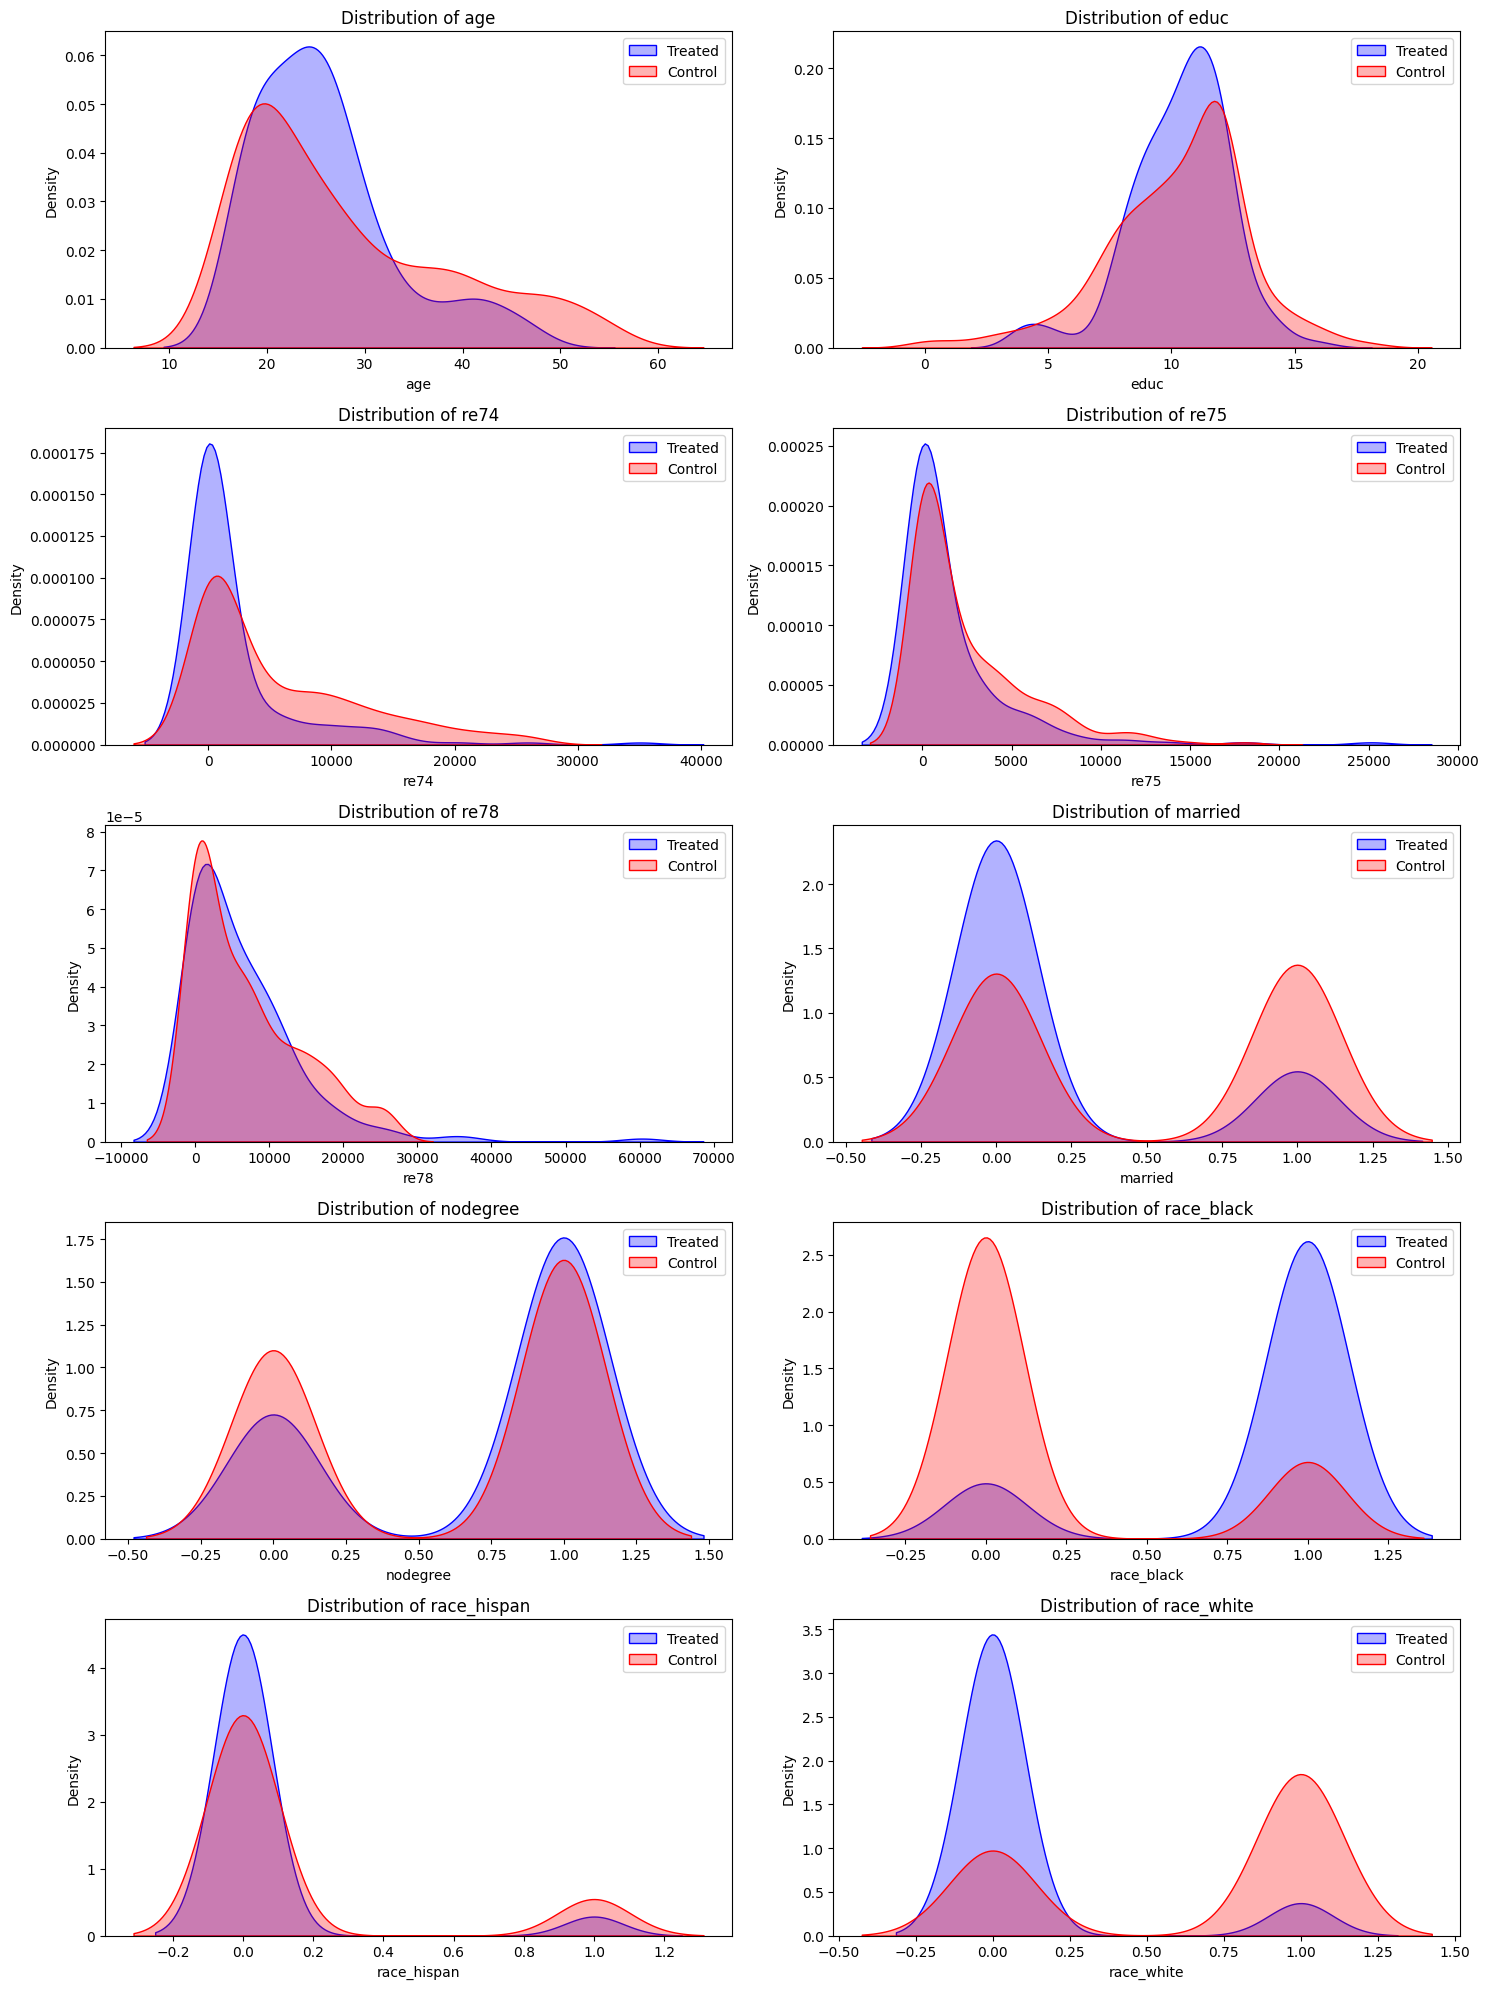

In [11]:
features = ['age', 'educ', 're74', 're75', 're78', 'married', 'nodegree', 'race_black', 'race_hispan', 'race_white']

# subplotting
n_cols = 2
n_rows = 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.kdeplot(data=df_encoded[df_encoded['treat'] == 1], x=col, label='Treated', ax=axes[i], fill=True, color='blue', alpha=0.3)
    sns.kdeplot(data=df_encoded[df_encoded['treat'] == 0], x=col, label='Control', ax=axes[i], fill=True, color='red', alpha=0.3)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend()

plt.tight_layout()
plt.savefig('Images/lalonde_distributions.png')
plt.show()

The control group definitely has a long tail for age, edcuation years, and 1974 earnings. There a large spike for the treated group at 0 1974 earnings. So it seems that this study was also comparing several unemployed individuals with those in an established job.

# Propensity Matching

What we now want to find is the probability of being in the treatment group given the above variables we looked at. If someone from the control has the same score as someone from the treatment, and they both recieved different earnings, then we can confidenly say the training program was effective (or not).

## Logistic Regression

Logistic Regression is commonly used in propensity mdoels for its probability curves. Since we only have 614 rows, I'll skip the usual train/test splits and normalize the features

In [64]:
features = ['age', 'educ', 're74', 're75', 'married', 'nodegree', 'race_black', 'race_hispan', 'race_white']
X = df_encoded[features]
y = df_encoded['treat'] 
# normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded[features])
# run logistic regression
ps_model = LogisticRegression(max_iter=1000, random_state=42)
ps_model.fit(X_scaled, y)
df_encoded['pscore'] = ps_model.predict_proba(X_scaled)[:, 1]
print(f"{ps_model.n_iter_[0]} iterations")

df_encoded[['treat', 'pscore']].head()

9 iterations


,treat,pscore
0,1,0.632972
1,1,0.224949
2,1,0.676719
3,1,0.771099
4,1,0.699196


## Love Plot

A love plot visualizes how the standard mean difference (SMD) between features/covariates changed after propensity score matching. For each treated individual, We take the closest propensity score match from the control and compare the new SMD with original. SMD = 0 means the groups have the exact same mean; other values show how many standard deviations apart they are.

We want to see the variable's new SMD values fall within -0.1 and 0.1 to be considered balance.

<>:27: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:27: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
C:\Users\nicho\AppData\Local\Temp\ipykernel_13908\1298188053.py:27: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
  plt.savefig('images\lalonde_love_plot.png')


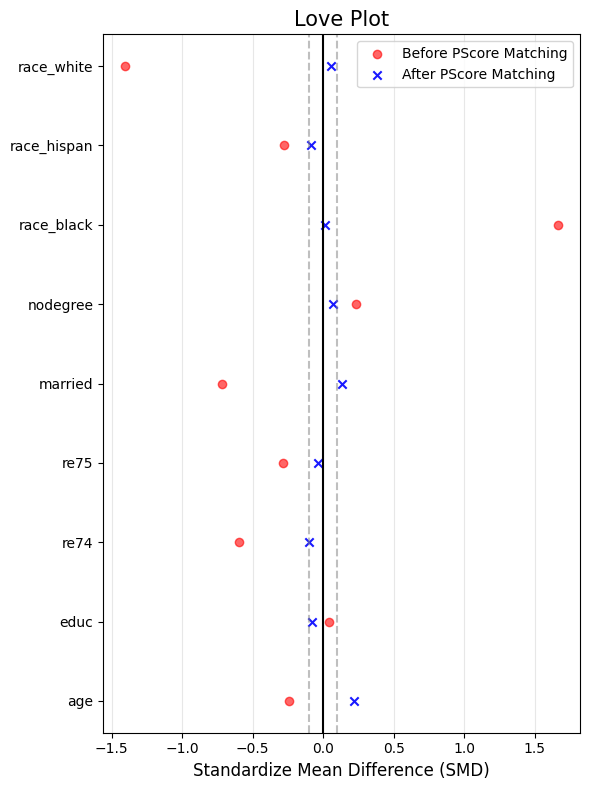

In [65]:
treated = df_encoded[df_encoded['treat'] == 1].copy()
control = df_encoded[df_encoded['treat'] == 0].copy()

# cluster to find the closest control person for each treated person
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['pscore']])
distances, indices = nn.kneighbors(treated[['pscore']])
# print(distances.flatten(), indices.flatten())
matched_control = control.iloc[indices.flatten()].copy()
df_matched = pd.concat([treated, matched_control])

smd_before = calculate_smd(df_encoded,features)
smd_after = calculate_smd(df_matched, features)

# plotting
plt.figure(figsize=(6, 8))
plt.scatter(smd_before, features, label='Before PScore Matching', color='red', alpha=0.6, marker='o')
plt.scatter(smd_after, features, label='After PScore Matching', color='blue', alpha=0.9, marker='x')
plt.axvline(0, color='black', linestyle='-')
plt.axvline(0.1, color='gray', linestyle='--', alpha=0.5)
plt.axvline(-0.1, color='gray', linestyle='--', alpha=0.5)
plt.title('Love Plot', fontsize=15)
plt.xlabel('Standardize Mean Difference (SMD)', fontsize=12)
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('images\lalonde_love_plot.png')

In [66]:
pd.concat([smd_before, smd_after], axis=1, keys=['Before Matching', 'After Matching'])
# smd_before, smd_after

,Before Matching,After Matching
age,-0.241904,0.218138
educ,0.044755,-0.076796
re74,-0.595752,-0.097435
re75,-0.287002,-0.038425
married,-0.719492,0.131035
nodegree,0.235048,0.070097
race_black,1.667719,0.014725
race_hispan,-0.276940,-0.084438
race_white,-1.405738,0.056765


* The love plot shows that our matching process balanced almost all of the vairables to near 0 SMD
* The largest changes were the race_white and race_black variables. The imbalance of participants' race was the major confounding factor in this experiment, and now the matchign process has created equal distributions.
* Age is still not balanced even after matching. This tells me that even between a pair fo similar earnings, age still plays a factor in how much you will get. The skewed age of the control leaning older may have negatively affected the experiemnt.

# Results / Discussion

Now that we have equal distributions between treated and control, we can confidently use a t-test to see if the NSW program created a significant difference in earnings.

In [74]:
# using variable re78 for earnings in 1978
treated_outcome = treated['re78']
control_outcome = matched_control['re78']
result = stats.ttest_ind(treated_outcome, control_outcome)

print(f"T-Test Results:")
print(f"Mean Earnings (Treated): ${np.mean(treated_outcome):.2f}")
print(f"Mean Earnings (Control): ${np.mean(control_outcome):.2f}")
print(f"Mean Treatment Effect: ${np.mean(treated_outcome) - np.mean(control_outcome):.2f}")
print(f"T-stat: {result.statistic:.4f}")
print(f"P-value: {result.pvalue:.4f}")
print(f"95% Confidence Interval: [${result.confidence_interval()[0]:.2f}, ${result.confidence_interval()[1]:.2f}]")

T-Test Results:
Mean Earnings (Treated): $6349.14
Mean Earnings (Control): $4971.10
Mean Treatment Effect: $1378.04
T-stat: 1.9050
P-value: 0.0576
95% Confidence Interval: [$-44.45, $2800.53]


**Does the training increase earnings for the treated group?** yes and no...

* The p-value is slightly above 0.05, so while we cannot reject the hypothesis that there's a significant difference in 1978 earnings between the treatment and control, I do think it is worth continuing the training program. We still see a positive average treatment lift of $1,378 per participant, and I believe the age of participants may be affecting the significance. 
* If we were to prolong the program, and possibly use a control with similar age ranges, we can gather more data and possibly have a more confident read out of these results. I recommend annual analysis for 1979 and 1980.

# References / Inspiration

* https://towardsdatascience.com/causal-inference-with-python-a-guide-to-propensity-score-matching-b3470080c84f/
* Lalonde, R. (1986). Evaluating the econometric evaluations of training programs with experimental data. American Economic Review 76: 604-620.
* Dehejia, R.H. and Wahba, S. (1999). Causal Effects in Nonexperimental Studies: Re-Evaluating the Evaluation of Training Programs. Journal of the American Statistical Association 94: 1053-1062.